## Authenticate to Colab, Cloud and GEE

In [ ]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Imperial_2'
model_dir = base_dir + 'models/'
IMAGES_PATH = base_dir + '/' + 'Imperial_2016_28c/'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


## Import Libraries

In [ ]:
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


# Initialize global variables and functions

In [ ]:
LABEL = 'landcover'


landcovers = ["Alfalfa", "Other Pasture", "Lettuce", "Wheat", "Onions", "Other Truck Crops", "Corn", "Other Field Crops",
             "Subtropical", "Other"]
# landcovers = ["Alfalfa", "Other Pasture", "Wheat", "Onion", "Lettuce", "Other crops","Subtropical", "Other"]


nClasses = len(landcovers)
r = 7

In [ ]:
new_labels = tf.constant([8, 8, 8, 8, 9, 6, 7, 7, 9, 3, 9, 0, 1, 1, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, 5, 9, 9, 9], dtype = tf.int32,)
# new_labels = tf.constant([6, 6, 6, 6, 7, 5, 5, 5, 7, 2, 7, 0, 1, 1, 5, 5, 5, 5, 4, 5, 5, 3, 5, 5, 5, 7, 7, 7], dtype = tf.int32)


new_labels

<tf.Tensor: shape=(28,), dtype=int32, numpy=
array([8, 8, 8, 8, 9, 6, 7, 7, 9, 3, 9, 0, 1, 1, 5, 5, 5, 5, 2, 5, 5, 4,
       5, 5, 5, 9, 9, 9], dtype=int32)>

In [ ]:
train_path = IMAGES_PATH + 'training_imperial_2016_28c'
validation_path = IMAGES_PATH + 'validation_imperial_2016_28c'
test_path = IMAGES_PATH + 'testing_imperial_2016_28c'

train_path = IMAGES_PATH + 'training_imperial_2016'
validation_path = IMAGES_PATH + 'validation_imperial_2016'
test_path = IMAGES_PATH + 'testing_imperial_2016'

train_file_prefix = 'training_imperial_2016'
validation_file_prefix = 'validation_imperial_2016'
test_file_prefix = 'testing_imperial_2016'

def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

train_dataset_paths = getDatasetPaths(train_path, train_file_prefix)
validation_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)


In [ ]:
# validation_dataset_paths

In [ ]:
FEATURE_NAMES = []
bands =  [
          'B2', 'B3', 'B4', 'B8', 'B11','B12', 'NDVI', 'GNDVI', 'EVI',
          'SAVI', 'BSI', 'NDWI', 'NDBI'
          ]
# bands =  ['NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']

# bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7']
# bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7','NDVI','EVI']

time_stamps = 9
# n_features = len(bands)
# for i in range(time_stamps):
#   if i > 0:
#     s = [b + '_' + str(i) for b in bands]
#   else:
#     s = bands
#   FEATURE_NAMES.extend(s)
# FEATURE_NAMES.append(LABEL)
for i in range(2,11):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)
FEATURE_NAMES

# Data preparation and pre-processing

In [ ]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES
]
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))

# pprint(featuresDict)

In [ ]:
# Create a dataset from the TFRecord file in Cloud Storage.

depth = len(FEATURE_NAMES)-1
def toTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    band_values = []
    for f in FEATURE_NAMES[i:i+n_features]:
      # if f.startswith('B'):
      #   band_values.append(tf.reshape(data[f],(r,r))/10000)
      # else:   
      #   band_values.append(tf.reshape(data[f],(r,r)))
      band_values.append(tf.reshape(data[f],(r,r)))
    spectral.append(band_values)
  
  spectral = tf.transpose(spectral, [2,3,0,1])
  label = tf.gather(new_labels, label)

  return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, label

def getDataset(datasetPaths):
  dataset = tf.data.TFRecordDataset(datasetPaths, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(toTuple)
  return inputDataset

trainDataset = getDataset(train_dataset_paths)
validationDataset = getDataset(validation_dataset_paths)
testDataset = getDataset(test_dataset_paths)
alltestDataset = validationDataset.concatenate(testDataset)

In [ ]:
for data, target in testDataset.take(5):
  print(data.shape)
  print(data[0][0])
  print(target)

(7, 7, 12, 13)
tf.Tensor(
[[ 1.19800000e+03  1.14100000e+03  1.15100000e+03  2.48400000e+03
   2.30200000e+03  1.50700000e+03  3.66712511e-01  3.70482773e-01
   8.20812798e+00  6.54307520e-03 -3.20953056e-02 -3.70482773e-01
  -3.80275808e-02]
 [ 1.03650000e+03  9.88500000e+02  8.67000000e+02  2.91350000e+03
   2.03650000e+03  1.19400000e+03  5.40864110e-01  4.92781907e-01
   1.50020676e+01 -9.99194607e-02 -1.53046995e-01 -4.92781907e-01
  -1.76867336e-01]
 [ 1.20500000e+03  1.18100000e+03  1.19800000e+03  2.68500000e+03
   2.54200000e+03  1.68100000e+03  3.82951319e-01  3.89032602e-01
   4.44411230e+00  1.07165370e-02 -1.96592398e-02 -3.89032602e-01
  -2.73579489e-02]
 [ 1.27800000e+03  1.30200000e+03  1.30900000e+03  2.90300000e+03
   2.79300000e+03  1.84500000e+03  3.78442556e-01  3.80737215e-01
   3.39727187e+00  4.02067788e-03 -9.53760743e-03 -3.80737215e-01
  -1.93117969e-02]
 [ 1.00200000e+03  9.48500000e+02  7.05000000e+02  3.88500000e+03
   1.75450000e+03  8.48000000e+02  6.928

# Models

##  Our 3DCNN

In [ ]:
pad = 'same'
l2 = 0
l1 = 0
f = [64, 128]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = ( r, r, time_stamps,n_features),),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(filters = f[0], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Conv3D(filters = f[1], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nClasses, activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Dense(nClasses, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 7, 7, 9, 13)       52        
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 7, 9, 64)       22528     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 9, 64)       256       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 9, 64)       0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 3, 3, 9, 64)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 3, 9, 128)      221312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 3, 9, 128)      5

## Paper 3D CNN

In [ ]:
pad = 'same'
l2 = 0
l1 = 0
f = [64, 128]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = ( r, r, time_stamps,n_features),),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(filters = f[0], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Conv3D(filters = f[1], kernel_size = (3, 3, 3), padding = 'same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AveragePooling3D(pool_size=(2, 2, 1)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(f[1], activation = 'relu',  kernel_regularizer=tf.keras.regularizers.L1L2(l2 = l2, l1 = l1)),
    tf.keras.layers.Dense(nClasses, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 7, 7, 12, 13)      52        
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 7, 7, 12, 64)      22528     
_________________________________________________________________
re_lu_14 (ReLU)              (None, 7, 7, 12, 64)      0         
_________________________________________________________________
average_pooling3d (AveragePo (None, 3, 3, 12, 64)      0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 3, 3, 12, 128)     221312    
_________________________________________________________________
re_lu_15 (ReLU)              (None, 3, 3, 12, 128)     0         
_________________________________________________________________
average_pooling3d_1 (Average (None, 1, 1, 12, 128)     0

## Conv3D w/ Conv1D

In [ ]:
input = tf.keras.layers.Input((r,r,time_stamps,n_features))
x = tf.keras.layers.BatchNormalization()(input)

x = tf.keras.layers.Conv3D(filters = 64, kernel_size = (3, 3, 3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool3D((2,2,1))(x)

x = tf.keras.layers.Conv3D(filters = 128, kernel_size = (3, 3, 3), padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPool3D((2,2,1))(x)
x = tf.squeeze(tf.squeeze(x, axis = 1), axis = 1)
x = tf.keras.layers.Conv1D(128, kernel_size = 3, padding = 'same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling1D()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(nClasses, activation = 'softmax')(x)
model = tf.keras.Model(input, x)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 7, 7, 12, 13)]    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 7, 7, 12, 13)      52        
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 7, 7, 12, 64)      22528     
_________________________________________________________________
batch_normalization_45 (Batc (None, 7, 7, 12, 64)      256       
_________________________________________________________________
re_lu_35 (ReLU)              (None, 7, 7, 12, 64)      0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 3, 3, 12, 64)      0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 3, 3, 12, 128)     221

# Training

In [ ]:
batch_size = 128
num_epochs = 60

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, min_lr=1e-10, min_delta=0.003, verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    model_dir + '/model2_3d1d_conv3d_2016_7x7x12x13_10c', monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)

optim = tf.keras.optimizers.Adam(learning_rate=0.0003)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

history = model.fit(trainDataset.batch(batch_size), 
                    batch_size=batch_size, 
                    epochs=num_epochs, verbose=1,
                    validation_data = alltestDataset.batch(batch_size),
                    callbacks = [reduce_lr, 
                                #  model_checkpoint_callback
                                 ]
)

Epoch 1/60
1635/1635 [==============================] - 185s 112ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 1.6132 - val_accuracy: 0.8466
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2models/model2_3d1d_conv3d_2016_7x7x12x13_10c/assets
Epoch 2/60
1635/1635 [==============================] - 184s 113ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 1.6889 - val_accuracy: 0.8455
Epoch 3/60
1635/1635 [==============================] - 183s 112ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 1.7224 - val_accuracy: 0.8474
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/Classification/USA/Imperial_2models/model2_3d1d_conv3d_2016_7x7x12x13_10c/assets
Epoch 4/60
1635/1635 [==============================] - 182s 111ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 1.7012 - val_accuracy: 0.8483

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002700000128243119.
INFO:tensorfl

In [ ]:

# model = tf.keras.models.load_model(model_dir + '/model_3d1d_conv3d_2016_7x7x9x13_10c') #81.23
# model = tf.keras.models.load_model(model_dir + '/model_conv3d_2016_7x7x9x13_10c') #80.73%
# model = tf.keras.models.load_model(model_dir + '/model_paper_conv3d_2016_7x7x9x13_10c')
#-----------------------------------------------------------------------------------------#
model = tf.keras.models.load_model(model_dir + '/model_3d1d_conv3d_2016_7x7x12x13_10c')


In [ ]:
 model.evaluate(alltestDataset.batch(1000))

135/135 [==============================] - 70s 512ms/step - loss: 1.5238 - accuracy: 0.8484


[1.5237715244293213, 0.8483676910400391]

# Analysis

In [ ]:
y_pred = np.argmax(model.predict(alltestDataset.batch(10000)),axis = 1)
y_true = tf.concat([y for x, y in alltestDataset], axis=0)
# f1_score(y_true.numpy(), y_pred, average = 'weighted')
cf = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

print(cf)
s = np.sum(cf, axis = 1)

cf1 = pd.DataFrame(cf/(s.reshape(10, 1))*100, columns=landcovers, index = landcovers)



[[39100  1095    27   101    11   282   269     2    26   205]
 [  643 19264   397   180    13   346   186    81    12   188]
 [  127    93  7654   164    82  1833   129    56     7  1145]
 [   19    35    69  5615    27   146   133     1     2    72]
 [   63    27    54   115  4158   214    55    47     2    41]
 [  473   286  1629   328   300 10811   211  1509    17   595]
 [  338   395   476    73   119   492  2414    37    12   210]
 [   17   132     7     0    21  1292    20  2384     1    23]
 [   26    14    10     6     4    24     6     9  2040   178]
 [  120   128   963   129    74   747    74     5    80 20875]]


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true.numpy(), y_pred, average = 'weighted')


0.8475647733108467

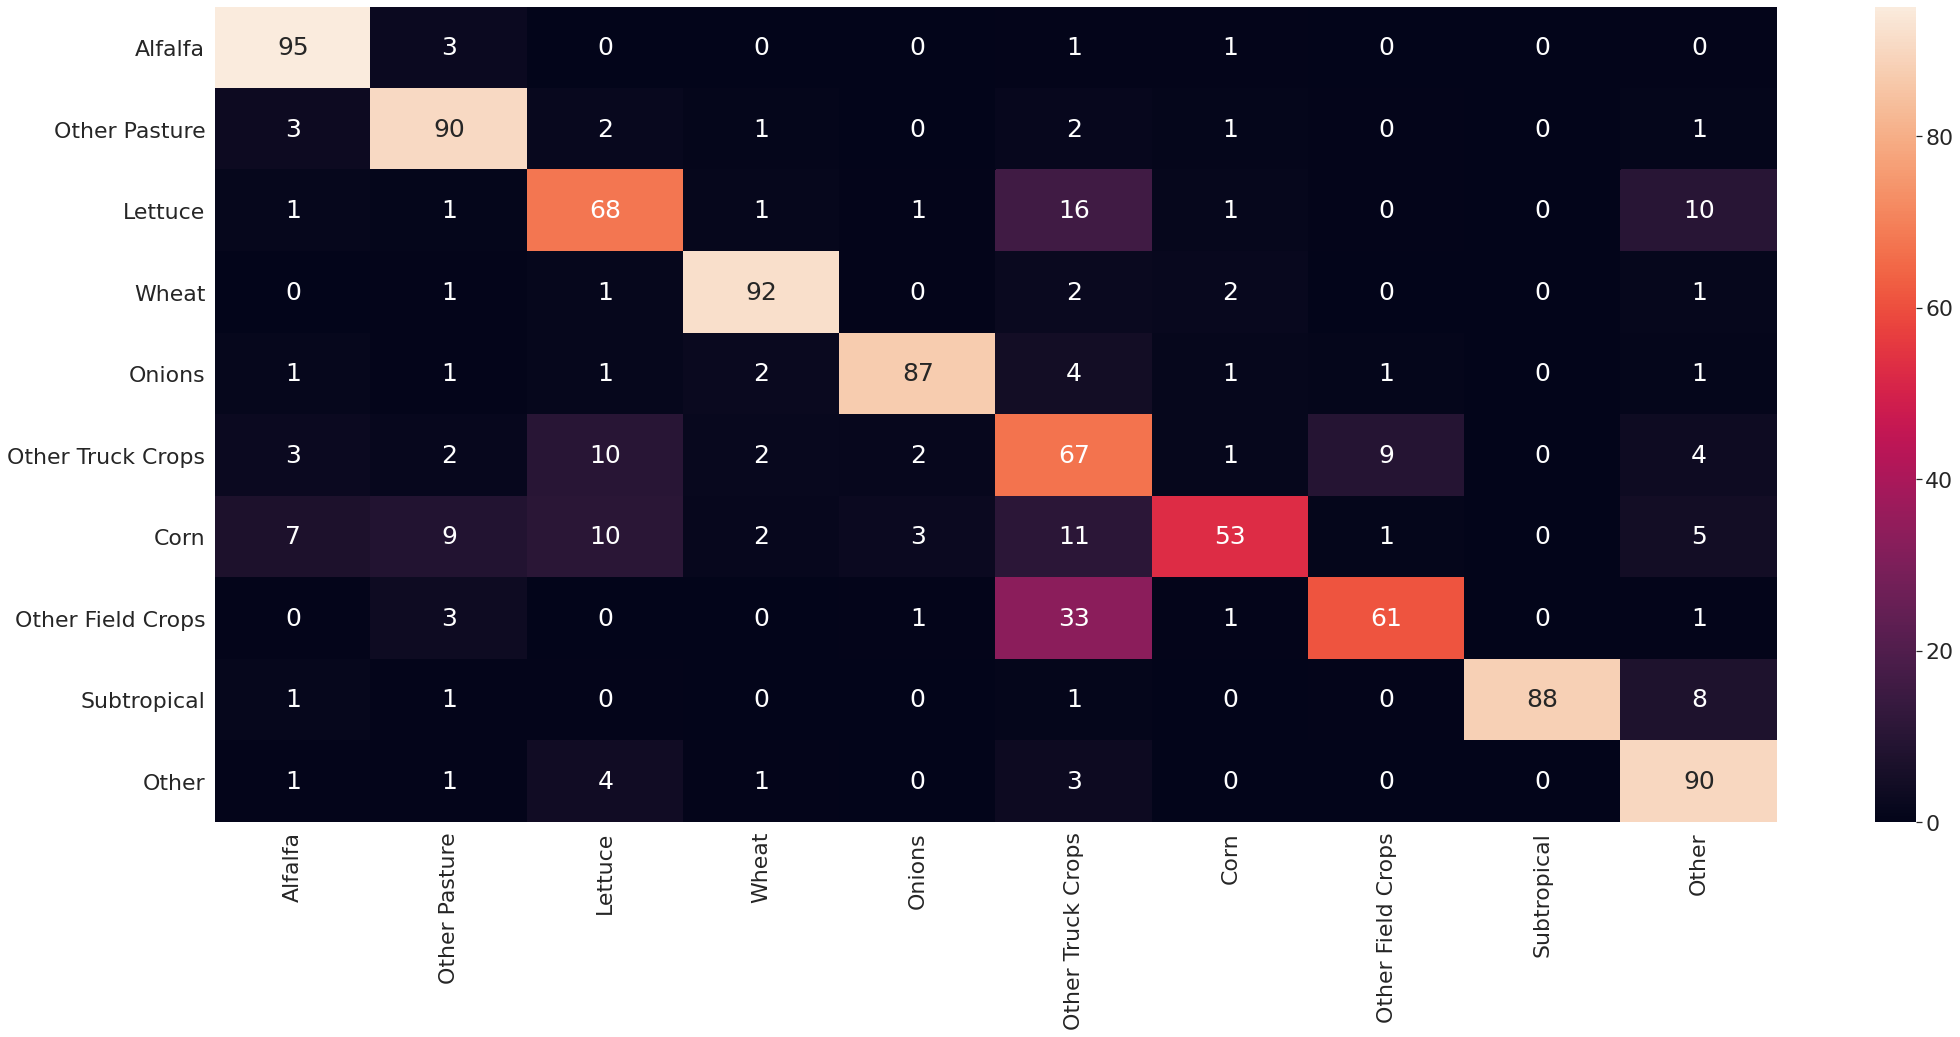

In [ ]:

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f')